# 1. Общее знакомство

In [ ]:
# %pip install 'etna[all]'

In [ ]:
import pandas as pd
import numpy as np

from etna.datasets.tsdataset import TSDataset

# модели
from etna.models import (NaiveModel,
                         MovingAverageModel,
                         SeasonalMovingAverageModel,
                         HoltWintersModel)

from etna.models import ProphetModel
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline


from etna.metrics import MAE, MSE, SMAPE, MAPE

# аналитика
from etna.analysis import plot_forecast
from etna.analysis import plot_backtest
from etna.analysis import plot_feature_relevance
from etna.analysis import ModelRelevanceTable
from statsmodels.graphics.tsaplots import plot_acf

# трансформации
from etna.transforms import MeanTransform, LagTransform
from sklearn.ensemble import RandomForestRegressor


# %config InlineBackend.figure_format = 'retina'

In [ ]:
import warnings
warnings.filterwarnings('ignore')


SMAPE:
**Symmetric mean absolute percentage error** (**SMAPE** or **sMAPE**) — это мера точности, основанная на процентных (или относительных) ошибках. Обычно его определяют следующим образом:


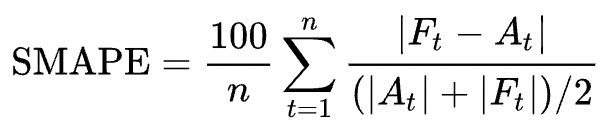

где At — фактическое значение, а Ft — прогнозное значение.

## 1.1. Данные


In [ ]:
# загружаем набор о ежемесячных продажах вина в Австралии
original_df = pd.read_csv('monthly_australian_wine_sales.csv')
original_df.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


In [ ]:
# задаём обязательные столбцы target, timestamp и segment
#

original_df['timestamp'] = pd.to_datetime(original_df['month'])
original_df['target'] = original_df['sales']


original_df.drop(columns=['month', 'sales'], inplace=True)
original_df['segment'] = 'main'
original_df.head()

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


In [ ]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq='MS')
ts.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


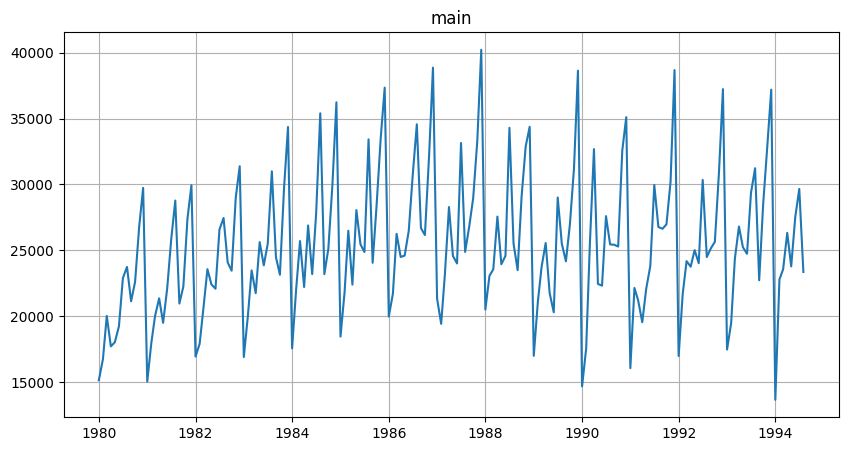

In [ ]:
ts.plot()

In [ ]:
# смотрим базовые характеристики
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1980-01-01,1994-08-01,176,0,1,0,0,0,MS


In [ ]:
# разбиваем набор на обучающую и тестовую выборки с учётом временной структуры
train_ts, test_ts = ts.train_test_split(train_start='1980-01-01',
                                        train_end='1993-12-01',
                                        test_start='1994-01-01',
                                        test_end='1994-08-01')

In [ ]:
HORIZON = 8

# 2. Модель наивного прогноза

In [ ]:
train_ts

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019
...,...
1993-08-01,31234
1993-09-01,22724


In [ ]:
test_ts

segment,main
feature,target
timestamp,
1994-01-01,13652
1994-02-01,22784
1994-03-01,23565
1994-04-01,26323
1994-05-01,23779
1994-06-01,27549
1994-07-01,29660
1994-08-01,23356


In [ ]:
model = NaiveModel(lag=1)
model.fit(train_ts)

future_ts = train_ts.make_future(future_steps=HORIZON,
                                 tail_steps=model.context_size # =1
                                )
future_ts

segment,main
feature,target
timestamp,
1993-12-01,37198.0
1994-01-01,NaN
1994-02-01,NaN
1994-03-01,NaN
1994-04-01,NaN
1994-05-01,NaN
1994-06-01,NaN
1994-07-01,NaN


In [ ]:
forecast_ts = model.forecast(future_ts,
                             prediction_size=HORIZON)
forecast_ts

segment,main
feature,target
timestamp,
1994-01-01,37198.0
1994-02-01,37198.0
1994-03-01,37198.0
1994-04-01,37198.0
1994-05-01,37198.0
1994-06-01,37198.0
1994-07-01,37198.0
1994-08-01,37198.0


In [ ]:
train_ts

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019
...,...
1993-08-01,31234
1993-09-01,22724


In [ ]:
model = NaiveModel(lag=3)
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON,
                                 tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts,
                             prediction_size=HORIZON)
forecast_ts

segment,main
feature,target
timestamp,
1994-01-01,28496.0
1994-02-01,32857.0
1994-03-01,37198.0
1994-04-01,28496.0
1994-05-01,32857.0
1994-06-01,37198.0
1994-07-01,28496.0
1994-08-01,32857.0


In [ ]:
model = NaiveModel(lag=12)
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON,
                                 tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts,
                             prediction_size=HORIZON)
forecast_ts

segment,main
feature,target
timestamp,
1994-01-01,17466.0
1994-02-01,19463.0
1994-03-01,24352.0
1994-04-01,26805.0
1994-05-01,25236.0
1994-06-01,24735.0
1994-07-01,29356.0
1994-08-01,31234.0


In [ ]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 11.492045838249387}

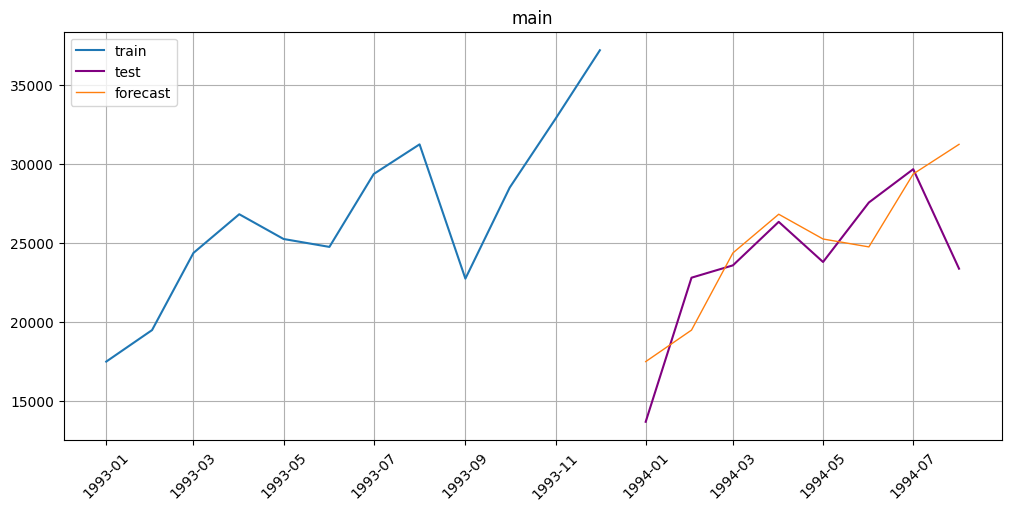

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=12)

# 3. Модель скользящего среднего

In [ ]:
model = MovingAverageModel(window=5)

model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON,
                                 tail_steps=model.context_size)
forecast_ts = model.forecast(future_ts,
                             prediction_size=HORIZON)
forecast_ts

segment,main
feature,target
timestamp,
1994-01-01,30501.800000
1994-02-01,30355.360000
1994-03-01,31881.632000
1994-04-01,32558.758400
1994-05-01,32499.110080
1994-06-01,31559.332096
1994-07-01,31770.838515
1994-08-01,32053.934218


In [ ]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 29.85307984438601}

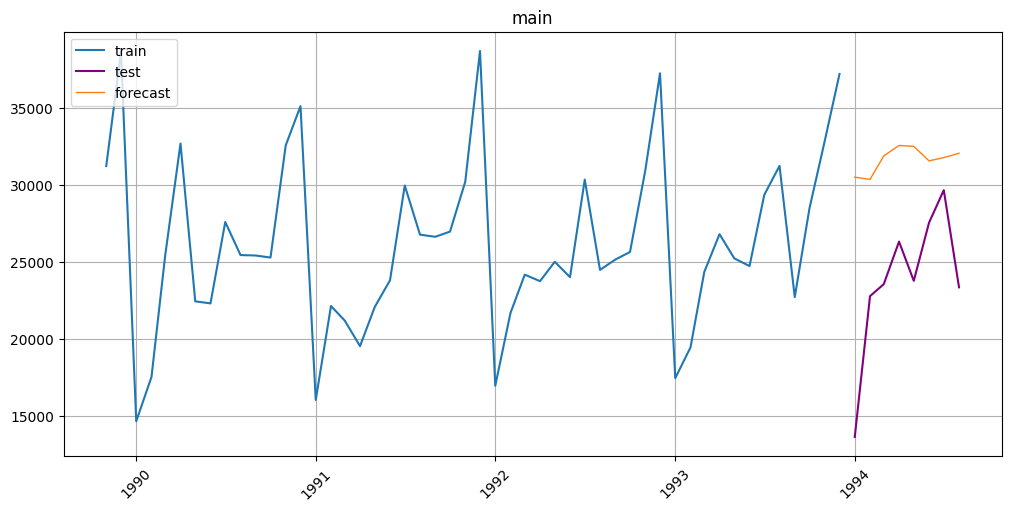

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=50)

In [ ]:
window = 5
seasonality = 1              # сезонность
shift = window * seasonality # смещение

series = original_df['target'][-shift:].values
series

array([26323, 23779, 27549, 29660, 23356], dtype=int64)

In [ ]:
res = np.append(series, np.zeros(HORIZON))
print(res, '\n\n')

for i in range(shift, len(res)):
    print(f'slice : {i - shift}, {i}, {seasonality}, arr: {res[i - shift : i : seasonality]}')

    res[i] = res[i - shift : i : seasonality].mean()
    print(res[i], '\n---')
    y_pred = res[-HORIZON:]

[26323. 23779. 27549. 29660. 23356.     0.     0.     0.     0.     0.
     0.     0.     0.] 


slice : 0, 5, 1, arr: [26323. 23779. 27549. 29660. 23356.]
26133.4 
---
slice : 1, 6, 1, arr: [23779.  27549.  29660.  23356.  26133.4]
26095.48 
---
slice : 2, 7, 1, arr: [27549.   29660.   23356.   26133.4  26095.48]
26558.776 
---
slice : 3, 8, 1, arr: [29660.    23356.    26133.4   26095.48  26558.776]
26360.7312 
---
slice : 4, 9, 1, arr: [23356.     26133.4    26095.48   26558.776  26360.7312]
25700.87744 
---
slice : 5, 10, 1, arr: [26133.4     26095.48    26558.776   26360.7312  25700.87744]
26169.852928 
---
slice : 6, 11, 1, arr: [26095.48     26558.776    26360.7312   25700.87744  26169.852928]
26177.1435136 
---
slice : 7, 12, 1, arr: [26558.776     26360.7312    25700.87744   26169.852928  26177.1435136]
26193.47621632 
---


# 4. Модель сезонного скользящего среднего

In [ ]:
model = SeasonalMovingAverageModel(window=5, seasonality=12)
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON,
                                 tail_steps=model.context_size)

forecast_ts = model.forecast(future_ts,
                             prediction_size=HORIZON)
forecast_ts

segment,main
feature,target
timestamp,
1994-01-01,16431.0
1994-02-01,20391.6
1994-03-01,23784.4
1994-04-01,25668.0
1994-05-01,23306.8
1994-06-01,23036.0
1994-07-01,29253.2
1994-08-01,26689.2


In [ ]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 8.444354755762415}

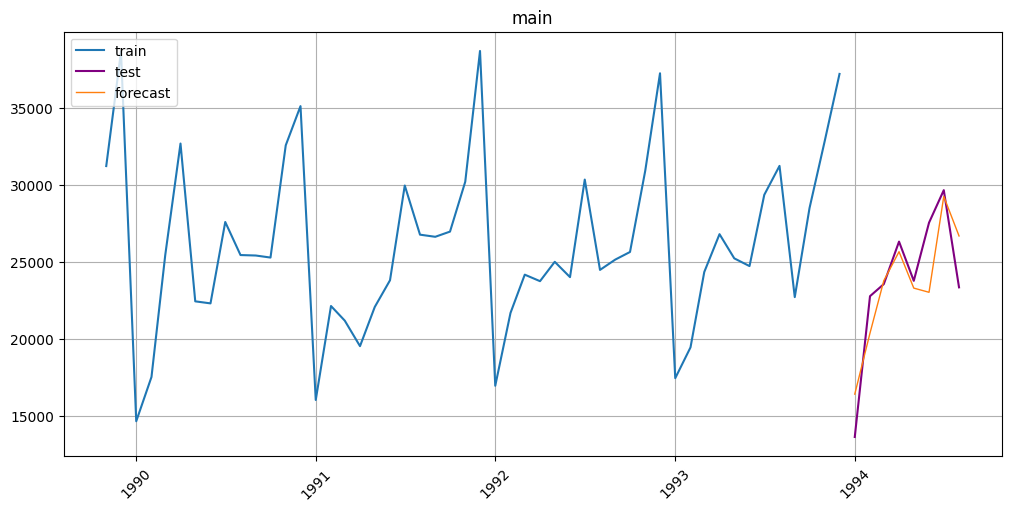

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=50)

Комментарий: повторение принципа работы модели

In [ ]:
window = 5                   # ширина окна
seasonality = 12             # сезонность
shift = window * seasonality # смещение

targets = original_df[0:len(original_df) - HORIZON]['target']

series = targets[-shift:].values
series

array([16991, 21109, 23740, 25552, 21752, 20294, 29009, 25500, 24166,
       26960, 31222, 38641, 14672, 17543, 25453, 32683, 22449, 22316,
       27595, 25451, 25421, 25288, 32568, 35110, 16052, 22146, 21198,
       19543, 22084, 23816, 29961, 26773, 26635, 26972, 30207, 38687,
       16974, 21697, 24179, 23757, 25013, 24019, 30345, 24488, 25156,
       25650, 30923, 37240, 17466, 19463, 24352, 26805, 25236, 24735,
       29356, 31234, 22724, 28496, 32857, 37198], dtype=int64)

In [ ]:
res = np.append(series, np.zeros(HORIZON))
print(res, end='\n\n')

# берём значения этого месяца в предыдущие годы
for i in range(shift, len(res)):
    print(res[i - shift : i : seasonality])
    res[i] = res[i - shift : i : seasonality].mean()

    print(res[i])
    y_pred = res[-HORIZON:]

[16991. 21109. 23740. 25552. 21752. 20294. 29009. 25500. 24166. 26960.
 31222. 38641. 14672. 17543. 25453. 32683. 22449. 22316. 27595. 25451.
 25421. 25288. 32568. 35110. 16052. 22146. 21198. 19543. 22084. 23816.
 29961. 26773. 26635. 26972. 30207. 38687. 16974. 21697. 24179. 23757.
 25013. 24019. 30345. 24488. 25156. 25650. 30923. 37240. 17466. 19463.
 24352. 26805. 25236. 24735. 29356. 31234. 22724. 28496. 32857. 37198.
     0.     0.     0.     0.     0.     0.     0.     0.]

[16991. 14672. 16052. 16974. 17466.]
16431.0
[21109. 17543. 22146. 21697. 19463.]
20391.6
[23740. 25453. 21198. 24179. 24352.]
23784.4
[25552. 32683. 19543. 23757. 26805.]
25668.0
[21752. 22449. 22084. 25013. 25236.]
23306.8
[20294. 22316. 23816. 24019. 24735.]
23036.0
[29009. 27595. 29961. 30345. 29356.]
29253.2
[25500. 25451. 26773. 24488. 31234.]
26689.2


# 5. Модель SARIMAX

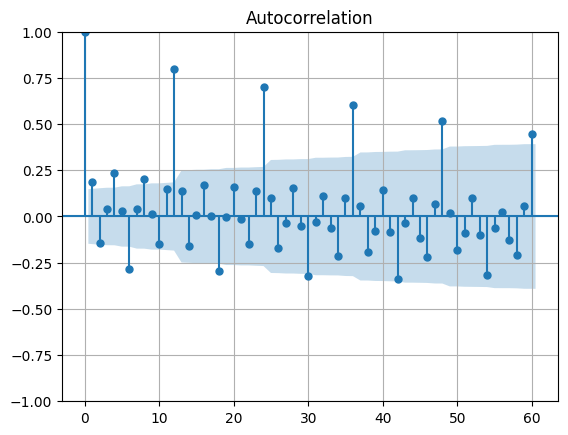

In [ ]:
# автокорреляционная функция
import matplotlib.pyplot as plt

_ = plot_acf(original_df.target, lags=60)
plt.grid()

In [ ]:
from etna.models import SARIMAXModel

model = SARIMAXModel(order=(1, 1, 1),
                            # MA(1), AR(1), d=1
                     seasonal_order=(1, 1, 0, 12))
                                    # MA(0), AR(1), d=1, s = 12,



model.fit(train_ts)

SARIMAXModel(order = (1, 1, 1), seasonal_order = (1, 1, 0, 12), trend = None, measurement_error = False, time_varying_regression = False, mle_regression = True, simple_differencing = False, enforce_stationarity = True, enforce_invertibility = True, hamilton_representation = False, concentrate_scale = False, trend_offset = 1, use_exact_diffuse = False, dates = None, freq = None, missing = 'none', validate_specification = True, fit_params = {}, )

In [ ]:
future_ts = train_ts.make_future(HORIZON)

forecast_ts = model.forecast(future_ts)
forecast_ts

segment,main
feature,target
timestamp,
1994-01-01,17967.731431
1994-02-01,20836.789962
1994-03-01,25133.857998
1994-04-01,26851.187262
1994-05-01,26010.258730
1994-06-01,25382.450493
1994-07-01,30442.443733
1994-08-01,30328.974659


In [ ]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 11.298184655637298}

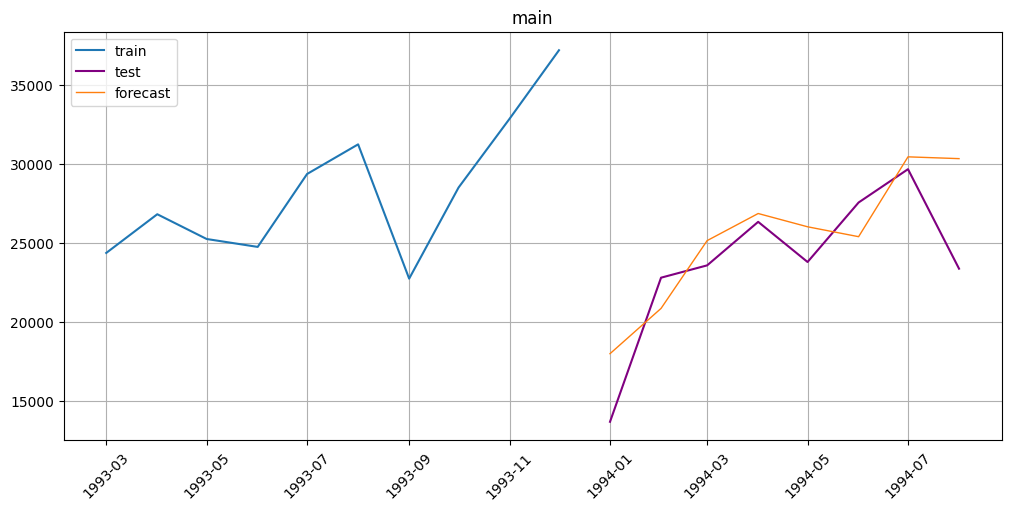

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

# 7. Модель Prophet

In [ ]:
model = ProphetModel()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

11:52:30 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.634152451904496}

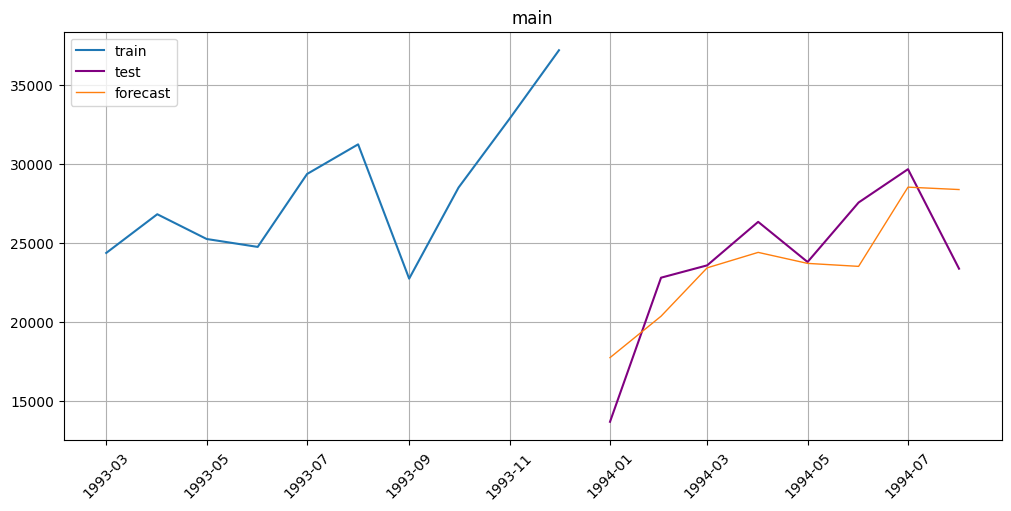

In [ ]:
plot_forecast(forecast_ts, test_ts,
              train_ts, n_train_samples=10)

## Pipelining

In [ ]:
pipeline = Pipeline(model=model, transforms=[], horizon=HORIZON)

Кросс-валидация (=backtest):


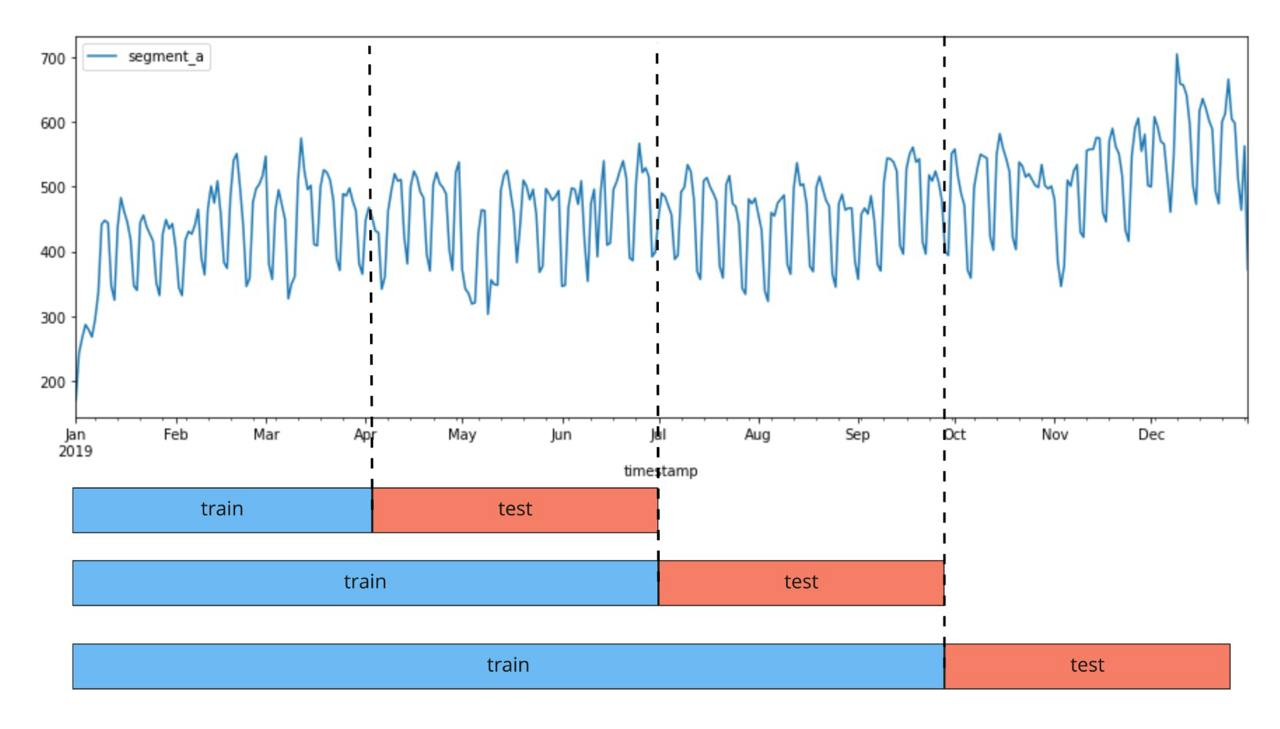

Дополнительный материал: https://docs.etna.ai/stable/tutorials/102-backtest.html

In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    mode='expand', ts=ts, metrics=[smape])

11:52:32 - cmdstanpy - INFO - Chain [1] start processing
11:52:32 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
11:52:32 - cmdstanpy - INFO - Chain [1] start processing
11:52:32 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.8s
11:52:33 - cmdstanpy - INFO - Chain [1] start processing
11:52:33 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.2s
11:52:33 - cmdstanpy - INFO - Chain [1] start processing
11:52:33 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    1.6s
11:52:34 - cmdstanpy - INFO - Chain [1] start processing
11:52:34 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Paralle

In [ ]:
metrics_df

,segment,SMAPE,fold_number
0,main,6.383926,0
0,main,6.323055,1
0,main,4.958183,2
0,main,7.232316,3
0,main,10.634152,4


In [ ]:
fold_info_df

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,1980-01-01,1991-04-01,1991-05-01,1991-12-01,0
1,1980-01-01,1991-12-01,1992-01-01,1992-08-01,1
2,1980-01-01,1992-08-01,1992-09-01,1993-04-01,2
3,1980-01-01,1993-04-01,1993-05-01,1993-12-01,3
4,1980-01-01,1993-12-01,1994-01-01,1994-08-01,4


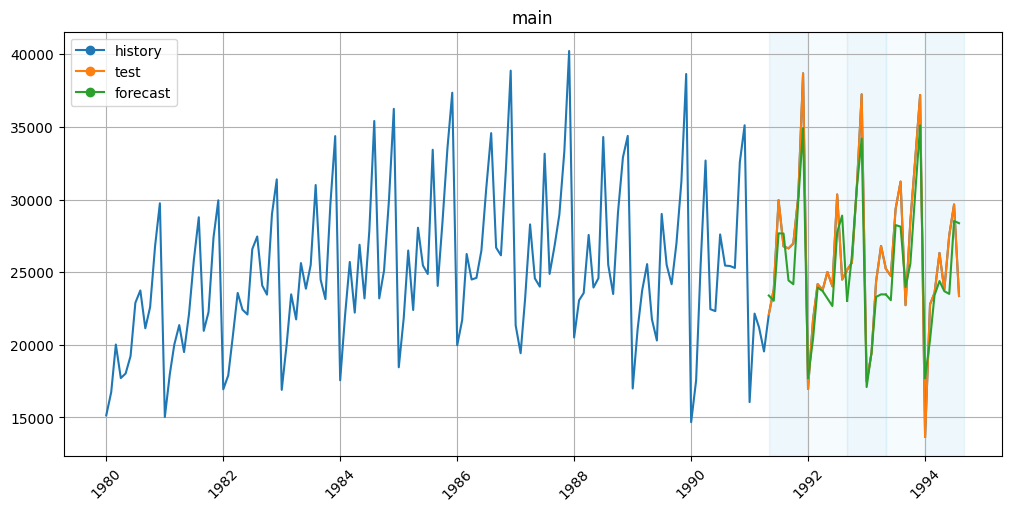

In [ ]:
plot_backtest(forecast_df, ts, history_len=137)

# 8. Модель CatBoost

Создание и оценка важности признаков:

In [ ]:
from copy import deepcopy
mean7 = MeanTransform(in_column='target',
                      window=7,
                      out_column='mean_07')

mean8 = MeanTransform(in_column='target',
                      window=8,
                      out_column='mean_08')
mean9 = MeanTransform(in_column='target',
                      window=9,
                      out_column='mean_09')
mean10 = MeanTransform(in_column='target',
                      window=10,
                      out_column='mean_10')
mean11 = MeanTransform(in_column='target',
                      window=11,
                      out_column='mean_11')

lags = LagTransform(in_column='target',
                    lags=list(range(6, 10, 1)),
                    out_column='lag')
train_ts_cat = deepcopy(train_ts)
train_ts_cat.fit_transform([mean7, mean8, mean9, mean10, mean11, lags])
train_ts_cat.tail()

segment        main                                                      \
feature       lag_6    lag_7    lag_8    lag_9       mean_07    mean_08   
timestamp                                                                 
1993-08-01  19463.0  17466.0  37240.0  30923.0  25883.000000  24830.875   
1993-09-01  24352.0  19463.0  17466.0  37240.0  26348.857143  25488.125   
1993-10-01  26805.0  24352.0  19463.0  17466.0  26940.857143  26617.250   
1993-11-01  25236.0  26805.0  24352.0  19463.0  27805.428571  27680.375   
1993-12-01  24735.0  25236.0  26805.0  24352.0  29514.285714  28979.500   

segment                                                 
feature          mean_09  mean_10       mean_11 target  
timestamp                                               
1993-08-01  26209.666667  26681.0  26587.272727  31234  
1993-09-01  24596.777778  25861.1  26321.272727  22724  
1993-10-01  25822.333333  24986.7  26100.636364  28496  
1993-11-01  27310.555556  26525.8  25702.181818  32857  
1993-12-01  28737.888889  28299.3  27496.000000  37198

In [ ]:
train_ts_cat.head(10)

segment        main                                                         \
feature       lag_6    lag_7    lag_8    lag_9       mean_07       mean_08   
timestamp                                                                    
1980-01-01      NaN      NaN      NaN      NaN  15136.000000  15136.000000   
1980-02-01      NaN      NaN      NaN      NaN  15934.500000  15934.500000   
1980-03-01      NaN      NaN      NaN      NaN  17295.000000  17295.000000   
1980-04-01      NaN      NaN      NaN      NaN  17398.250000  17398.250000   
1980-05-01      NaN      NaN      NaN      NaN  17522.400000  17522.400000   
1980-06-01      NaN      NaN      NaN      NaN  17806.500000  17806.500000   
1980-07-01  15136.0      NaN      NaN      NaN  18533.142857  18533.142857   
1980-08-01  16733.0  15136.0      NaN      NaN  19762.142857  19183.875000   
1980-09-01  20016.0  16733.0  15136.0      NaN  20390.714286  19933.500000   
1980-10-01  17708.0  20016.0  16733.0  15136.0  20758.571429  20665.750000   

segment                                                      
feature          mean_09       mean_10       mean_11 target  
timestamp                                                    
1980-01-01  15136.000000  15136.000000  15136.000000  15136  
1980-02-01  15934.500000  15934.500000  15934.500000  16733  
1980-03-01  17295.000000  17295.000000  17295.000000  20016  
1980-04-01  17398.250000  17398.250000  17398.250000  17708  
1980-05-01  17522.400000  17522.400000  17522.400000  18019  
1980-06-01  17806.500000  17806.500000  17806.500000  19227  
1980-07-01  18533.142857  18533.142857  18533.142857  22893  
1980-08-01  19183.875000  19183.875000  19183.875000  23739  
1980-09-01  19400.444444  19400.444444  19400.444444  21133  
1980-10-01  20228.777778  19719.500000  19719.500000  22591

In [ ]:
future_ts = train_ts_cat.make_future(
    HORIZON,
    [mean7, mean8, mean9,
     mean10, mean11, lags])
future_ts

segment        main                                                         \
feature       lag_6    lag_7    lag_8    lag_9       mean_07       mean_08   
timestamp                                                                    
1994-01-01  29356.0  24735.0  25236.0  26805.0  30310.833333  29514.285714   
1994-02-01  31234.0  29356.0  24735.0  25236.0  30501.800000  30310.833333   
1994-03-01  22724.0  31234.0  29356.0  24735.0  30318.750000  30501.800000   
1994-04-01  28496.0  22724.0  31234.0  29356.0  32850.333333  30318.750000   
1994-05-01  32857.0  28496.0  22724.0  31234.0  35027.500000  32850.333333   
1994-06-01  37198.0  32857.0  28496.0  22724.0  37198.000000  35027.500000   
1994-07-01      NaN  37198.0  32857.0  28496.0      0.000000  37198.000000   
1994-08-01      NaN      NaN  37198.0  32857.0      0.000000      0.000000   

segment                                                      
feature          mean_09       mean_10       mean_11 target  
timestamp                                                    
1994-01-01  28979.500000  28737.888889  28299.300000    NaN  
1994-02-01  29514.285714  28979.500000  28737.888889    NaN  
1994-03-01  30310.833333  29514.285714  28979.500000    NaN  
1994-04-01  30501.800000  30310.833333  29514.285714    NaN  
1994-05-01  30318.750000  30501.800000  30310.833333    NaN  
1994-06-01  32850.333333  30318.750000  30501.800000    NaN  
1994-07-01  35027.500000  32850.333333  30318.750000    NaN  
1994-08-01  37198.000000  35027.500000  32850.333333    NaN

CatBoost model (модель градиентного бустинга):

In [ ]:
model = CatBoostMultiSegmentModel(loss_function='MAE',
                                  n_estimators=600,
                                  learning_rate=0.05,
                                  depth=9,
                                  random_seed=42)
model.fit(train_ts_cat)

forecast_ts = model.forecast(future_ts)

In [ ]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 20.801750985543485}

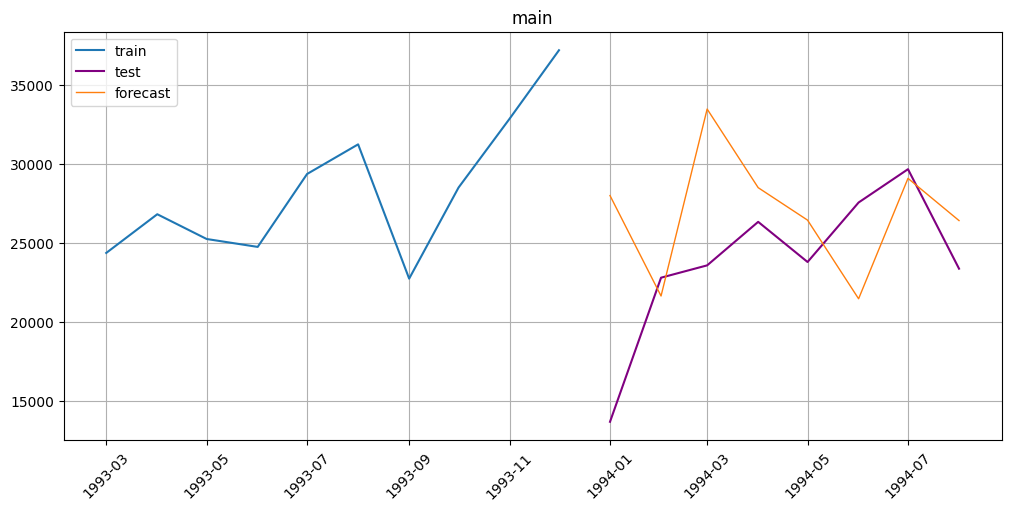

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts_cat, n_train_samples=10)

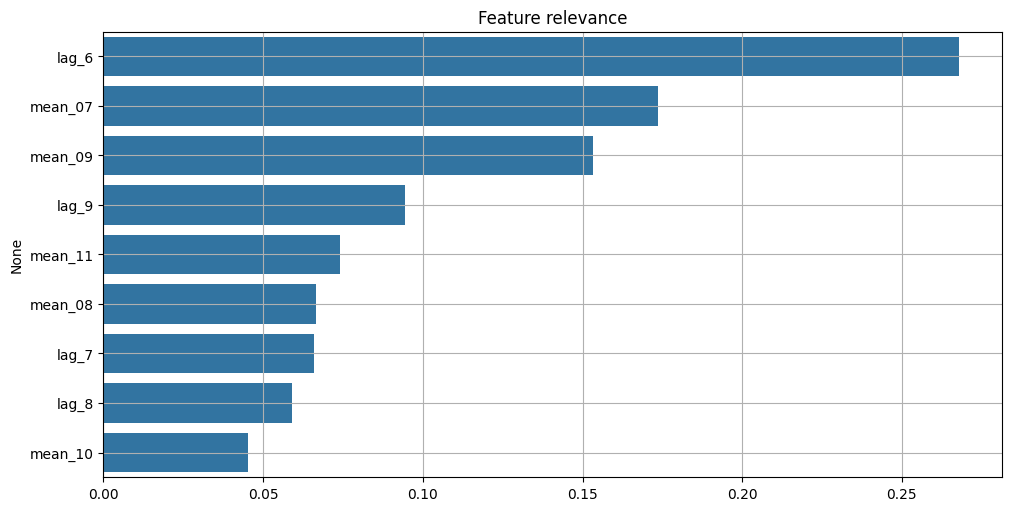

In [ ]:
# выведем график топ-20 важных признаков

plot_feature_relevance(
    ts=train_ts,
    relevance_table=ModelRelevanceTable(),
    normalized=True,
    top_k=20,
    relevance_params=dict(
        model=RandomForestRegressor(n_estimators=100)
        )
)

Подбор гиперпараметров:

In [ ]:
def etna_validation_optimize(ts,
                             train_start,
                             train_end,
                             valid_start,
                             valid_end,
                             model,
                             horizon,
                             transfrms,
                             metrics):
    """
    Выполняет подбор гиперпараметра — набора преобразований/
    признаков с помощью валидационной выборки
    """

    best_score = np.inf

    for trans in transfrms:
        train_ts, valid_ts = ts.train_test_split(train_start=train_start,
                                                 train_end=train_end,
                                                 test_start=valid_start,
                                                 test_end=valid_end)
        pipe = Pipeline(
            model=model,
            transforms=trans,
            horizon=horizon)

        pipe.fit(train_ts)
        forecast_ts = pipe.forecast()
        metrics_score = metrics(y_true=valid_ts,
                                y_pred=forecast_ts).get('main')

        print(f"trans:\n{trans}")
        print(f"{metrics.__class__.__name__}: {metrics_score}\n")

        if metrics_score < best_score:
            best_score = metrics_score
            best_parameters = {'trans': trans}

    print(f"Наилучший набор преобразований/признаков:\n{best_parameters}\n")
    print(f"Лучшее значение {metrics.__class__.__name__}: {best_score:.4f}\n")

In [ ]:
lags = LagTransform(in_column='target',
                    lags=list(range(6, 10, 1)),
                    out_column='lag')

lags2 = LagTransform(in_column='target',
                     lags=list(range(8, 13, 1)),
                     out_column='lag')


etna_validation_optimize(ts,
                         train_start='1980-01-01',
                         train_end='1993-04-01',
                         valid_start='1993-05-01',
                         valid_end='1993-12-01',
                         model=model,
                         horizon=HORIZON,
                         transfrms=[[lags, mean8], [lags2, mean8]],
                         metrics=SMAPE())

trans:
[LagTransform(in_column = 'target', lags = [6, 7, 8, 9], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean_08', )]
SMAPE: 14.317898250932895

trans:
[LagTransform(in_column = 'target', lags = [8, 9, 10, 11, 12], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean_08', )]
SMAPE: 10.204354075542287

Наилучший набор преобразований/признаков:
{'trans': [LagTransform(in_column = 'target', lags = [8, 9, 10, 11, 12], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean_08', )]}

Лучшее значение SMAPE: 10.2044



# 9. Подбор гиперпараметров с помощью перекрёстной проверки

In [ ]:
transforms = [lags, mean8]

pipeline = Pipeline(model=model,
                    transforms=transforms,
                    horizon=HORIZON)

In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    mode='expand', ts=train_ts, metrics=[smape])

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   15.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   15.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

In [ ]:
# смотрим датафрейм с метриками по каждой
# тестовой выборке перекрёстной проверки
metrics_df

,segment,SMAPE,fold_number
0,main,21.833670,0
0,main,13.639624,1
0,main,12.849245,2
0,main,17.139242,3
0,main,14.317898,4


In [ ]:
print(metrics_df['SMAPE'].mean())
print(metrics_df['SMAPE'].std())

15.955935625412357
3.662238692353896


In [ ]:
transforms2 = [lags2, mean8]

In [ ]:
pipeline2 = Pipeline(model=model,
                     transforms=transforms2,
                     horizon=HORIZON)

In [ ]:
train_ts, test_ts = ts.train_test_split(train_start='1980-01-01',
                                        train_end='1993-12-01',
                                        test_start='1994-01-01',
                                        test_end='1994-08-01')

metrics_df2, forecast_df2, fold_info_df2 = pipeline2.backtest(
    mode='expand', ts=train_ts, metrics=[smape])

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   12.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   15.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   15.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

In [ ]:
# смотрим датафрейм с метриками по каждой
# тестовой выборке перекрёстной проверки
metrics_df2

,segment,SMAPE,fold_number
0,main,16.109081,0
0,main,11.264537,1
0,main,6.455346,2
0,main,5.699620,3
0,main,10.204354,4


In [ ]:
# вычислим среднее значение и стандартное отклонение SMAPE
print(metrics_df2['SMAPE'].mean())
print(metrics_df2['SMAPE'].std())


9.946587571595813
4.183457137940414


### Финальный метод для оптимизации гиперпараметров

In [ ]:
def etna_cv_optimize(ts, model, horizon, transfrms, n_folds,
                     mode, metrics, refit=True,
                     n_train_samples=10):
    """
    Выполняет подбор гиперпараметра — набора преобразований/
    признаков с помощью перекрёстной проверки
    """

    train_ts, test_ts = ts.train_test_split(test_size=horizon)

    best_score = np.inf

    for trans in transfrms:
        pipe = Pipeline(
            model=model,
            transforms=trans,
            horizon=horizon)

        df_metrics, _, _ = pipe.backtest(mode=mode,
                                         n_folds=n_folds,
                                         ts=train_ts,
                                         metrics=[metrics],
                                         aggregate_metrics=False)

        metrics_mean = df_metrics[metrics.__class__.__name__].mean()
        metrics_std = df_metrics[metrics.__class__.__name__].std()

        print(f"trans:\n{trans}")
        print(f"{metrics.__class__.__name__}_mean: {metrics_mean}")
        print(f"{metrics.__class__.__name__}_std: {metrics_std}\n")

        if metrics_mean < best_score:
            best_score = metrics_mean
            best_parameters = {'trans': trans}

    print(f"Наилучший набор преобразований/признаков:\n{best_parameters}\n")
    print(f"Лучшее значение {metrics.__class__.__name__} cv: {best_score:.4f}\n")

    if refit:
        pipe = Pipeline(model=model,
                        transforms=best_parameters.get('trans'),
                        horizon=horizon)

        pipe.fit(train_ts)
        forecast_ts = pipe.forecast()
        print(metrics(y_true=test_ts, y_pred=forecast_ts))

        plot_forecast(forecast_ts, test_ts,
                      train_ts, n_train_samples=n_train_samples)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   14.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   14.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

trans:
[LagTransform(in_column = 'target', lags = [6, 7, 8, 9], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean_08', )]
SMAPE_mean: 15.955935625412357
SMAPE_std: 3.662238692353896



[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    8.9s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   12.0s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   15.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   15.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

trans:
[LagTransform(in_column = 'target', lags = [8, 9, 10, 11, 12], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean_08', )]
SMAPE_mean: 9.946587571595813
SMAPE_std: 4.183457137940414

Наилучший набор преобразований/признаков:
{'trans': [LagTransform(in_column = 'target', lags = [8, 9, 10, 11, 12], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean_08', )]}

Лучшее значение SMAPE cv: 9.9466

{'main': 11.123314225805467}


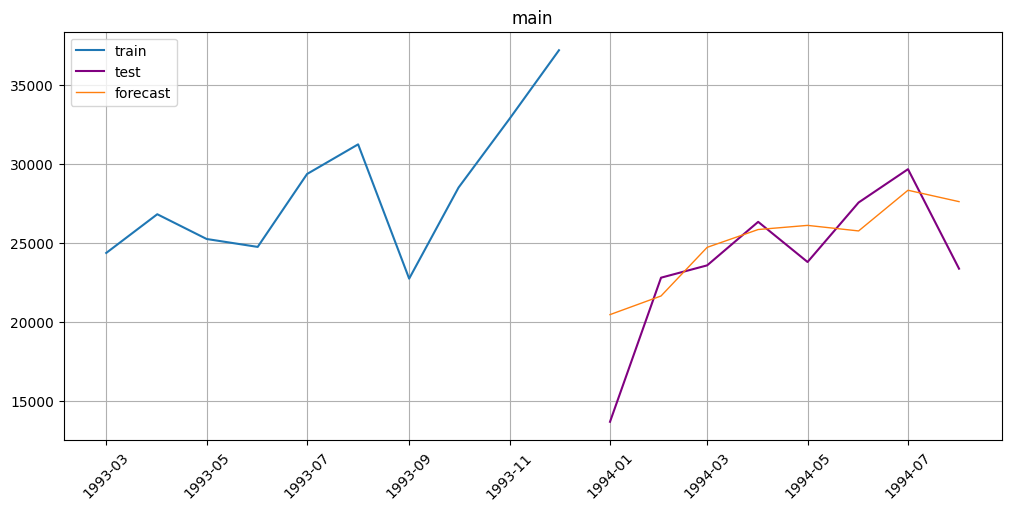

In [ ]:
etna_cv_optimize(ts=ts,
                 model=model,
                 horizon=HORIZON,
                 transfrms=[transforms, transforms2],
                 n_folds=5,
                 mode='expand',
                 metrics=SMAPE(),
                 refit=True)

# 10. Фукция обучения и оценки моделей

Объединение процедуры построения модели, оценки качества и визуализации прогнозов в одной функции.

In [ ]:
def train_and_evaluate_model(ts,
                             model,
                             transforms,
                             horizon,
                             metrics,
                             print_metrics=False,
                             print_plots=False,
                             n_train_samples=None):
    """
    Обучает модель, вычисляет прогнозы для
    тестовой выборки и строит график прогнозов
    """

    # if not print_plots and n_train_samples is not None:
    #     raise ValueError(
    #         "Параметр n_train_samples задаётся при print_plots=True")

    train_ts, test_ts = ts.train_test_split(test_size=horizon)
    pipe = Pipeline(model=model,
                    transforms=transforms,
                    horizon=horizon)
    pipe.fit(train_ts)
    forecast_ts = pipe.forecast()

    segment_metrics = metrics(test_ts, forecast_ts)
    segment_metrics = pd.Series(segment_metrics)

    if print_metrics:
        print(segment_metrics.to_string())
        print("")
        print(f"Усреднённая метрика:"
              f"{sum(segment_metrics) / len(segment_metrics)}")

    if print_plots:
        # визуализируем прогнозы, здесь n_train_samples
        # - n последних наблюдений в обучающей выборке
        plot_forecast(forecast_ts, test_ts,
                      train_ts, n_train_samples=n_train_samples)

main    17.263285

Усредненная метрика:17.263284720982046


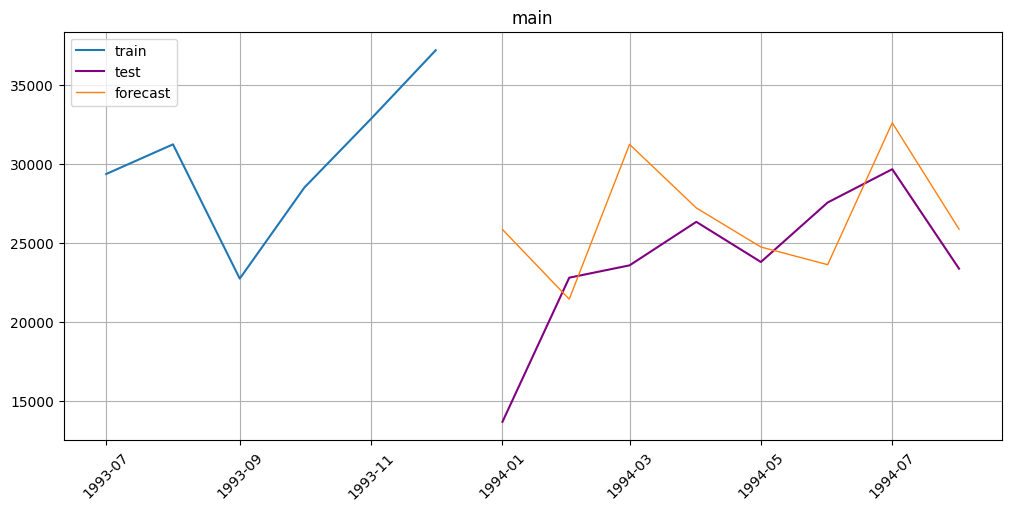

In [ ]:
# создаём экземпляр класса CatBoostMultiSegmentModel
model = CatBoostMultiSegmentModel(loss_function='MAE',
                                  n_estimators=600,
                                  learning_rate=0.05,
                                  depth=9,
                                  random_seed=42)

# задаём список преобразований
preprocess = [lags, mean8]

HORIZON = 8
smape = SMAPE()

# строим и оцениваем модель CatBoostMultiSegmentModel
train_and_evaluate_model(
    ts=ts,
    model=model,
    transforms=preprocess,
    horizon=HORIZON,
    metrics=smape,
    print_metrics=True,
    print_plots=True,
    n_train_samples=6)

## Итоговое сравнение моделей

In [ ]:
naive_pipeline = Pipeline(
   model=NaiveModel(lag=12), transforms=[], horizon=HORIZON
)

prophet_pipeline = Pipeline(
    model=ProphetModel(), transforms=[], horizon=HORIZON
)

sma_seasonality_12_pipeline = Pipeline(
    model=SeasonalMovingAverageModel(window=5, seasonality=12),
    transforms=[], horizon=HORIZON
)

sarimax_pipeline = Pipeline(
    model=SARIMAXModel(order=(0, 1, 1),
                       seasonal_order=(0, 1, 1, 12)),
    transforms=[], horizon=HORIZON
)

catboost_pipeline = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[mean7, mean8, mean9, mean10, mean11, lags],
    horizon=HORIZON
)



In [ ]:
pipeline_names = ['naive', 'prophet', 'sma_seasonality_12',
                  'sarimax', 'catboost',]

pipelines = [naive_pipeline, prophet_pipeline,
             sma_seasonality_12_pipeline,
             sarimax_pipeline, catboost_pipeline]

metrics = []

for pipeline in pipelines:
    metrics.append(
        pipeline.backtest(
            ts=ts, metrics=[MAE(), MSE(), SMAPE(), MAPE()],
            n_folds=3, aggregate_metrics=True)
            [0].iloc[:, 1:])

metrics = pd.concat(metrics)
metrics.index = pipeline_names

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
11:54:05 - cmdstanpy - INFO - Chain [1] start processing
11:54:05 - cmdstanpy - INFO - Chain [1] done processing
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
11:54:06 - cmdstanpy - INFO - Chain [1] start processing
11:54:06 - cmdstanpy - INFO - Chain [

# Таблица метрик качества моделей


In [ ]:
metrics

,MAE,MSE,SMAPE,MAPE
naive,1987.333333,7.688508e+06,8.062820,8.242755
prophet,1904.177567,5.510046e+06,7.608217,7.618285
sma_seasonality_12,1580.191667,4.394046e+06,6.512327,6.471100
sarimax,1786.116783,5.887926e+06,7.331672,7.640405
catboost,4709.786147,3.760501e+07,17.904942,19.529115



# Дополнительный материал (по желанию)

In [ ]:
from etna.ensembles import VotingEnsemble
from etna.ensembles import StackingEnsemble

### 12. Ансамбли

In [ ]:
# выбираем наиболее сильные модели
pipes = [prophet_pipeline, sma_seasonality_12_pipeline]


vot_ens = VotingEnsemble(pipelines=pipes,
                         weights=[0.5, 9], n_jobs=2)

vot_ens_metrics, vot_ens_forecasts, _ = vot_ens.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=3,
    aggregate_metrics=True,
    n_jobs=2,
)

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   21.9s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   34.1s finished
[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.0s finished


In [ ]:
# печатаем метрики
vot_ens_metrics


,segment,MAE,MSE,SMAPE,MAPE
0,main,1568.667798,4.345964e+06,6.474624,6.437885


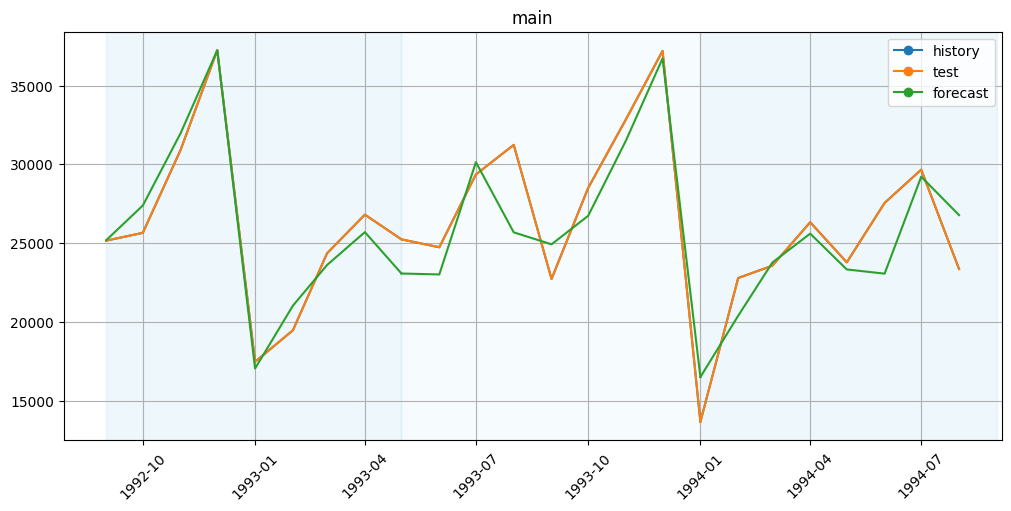

In [ ]:
# визуализируем результаты
plot_backtest(vot_ens_forecasts, ts)

### 13. Стекинг

In [ ]:
# рассматриваем все модели
pipelines = [naive_pipeline, prophet_pipeline,
             sma_seasonality_12_pipeline,
             sarimax_pipeline, catboost_pipeline]

stacking_ensemble_unfeatured = StackingEnsemble(
    features_to_use='None', pipelines=pipelines, n_folds=10, n_jobs=4)

In [ ]:
# выполняем стекинг
stacking_ensamble_metrics = stacking_ensemble_unfeatured.backtest(
    ts=ts, metrics=[MAE(), MSE(), SMAPE(), MAPE()], n_folds=3,
    aggregate_metrics=True, n_jobs=2)[0].iloc[:, 1:]

stacking_ensamble_metrics.index = ['stacking ensemble']

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   51.6s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:    1.3s finished


In [ ]:
stacking_ensamble_metrics


,MAE,MSE,SMAPE,MAPE
stacking ensemble,1843.121758,5.672253e+06,7.523719,7.454735


----------------

In [ ]:
# # 6. Модель Хольта — Винтерса
# model = HoltWintersModel(seasonal='additive',
#                          trend='additive',
#                          seasonal_periods=12,
#                          smoothing_level=0.05,
#                          smoothing_trend=0.01,
#                          smoothing_seasonal=0.35)

# model.fit(train_ts)

# future_ts = train_ts.make_future(HORIZON)
# forecast_ts = model.forecast(future_ts)

# print(smape(y_true=test_ts, y_pred=forecast_ts))
# plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)